In [1]:
import pennylane as qml
from pennylane import numpy as np
from featuremaps import *
from fidelity import predict
import matplotlib.pyplot as plt
import dill as pickle
import time
from generate_data import generate_data

In [2]:
np.set_printoptions(precision=5, suppress=True)

CSWAP = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1]])

In [18]:
########################
# Settings
########################
# FIX: For technical reasons, define all kwargs with fixed values (i.e. n_layers=1).
# Make sure these are consistent with the variables below.
n_l = 4
types = 2
circ_type = 1
data_dim = 1
repeated_data = False
if data_dim == 1:
    if repeated_data:
        X_data = 'X_1d2_sep.txt'
    else:
        X_data = 'X_1d_sep.txt'
    Y_data = 'Y_1d_sep.txt'
elif data_dim == 2:
    X_data = 'X_2d_sep.txt'
    Y_data = 'Y_2d_sep.txt'
    
def featmap(*args):
    """Wrapper for feature map to define specific keyword arguments."""
    if circ_type == 1:
        return qaoa(*args, n_layers=n_l, circuit_ID=types)
    elif circ_type ==2:
        return shallow_circuit(*args, n_layers=n_l, circuit_ID=types)
    elif circ_type ==3:
        return HVA_TFIM_2D_data(*args, n_layers=n_l, types=types)
    elif circ_type ==4:
        return HVA_TFIM_1D_data(*args, n_layers=n_l, types=types)
    else:
        return VQC(*args, n_layers=n_l, types=types)


n_layers = n_l  # number of layers for featuremap, if applicable
n_inp = 2  # number of wires that feature map acts on
n_steps = 300  # steps of GD performed
log_step = 5  # how often the test error is calculated
batch_size = 1  # how many pairs are sampled in each training step
X = np.loadtxt("./data/{}".format(X_data), ndmin=2)  # load features
Y = np.loadtxt("./data/{}".format(Y_data))  # load labels
name_output = "./trained_embeddings/1d_sep-l2-" + str(n_steps) + "s-" + \
              str(n_layers) + "l-" + str(n_inp) + "w"   # name of output file
if circ_type == 3:
    init_pars = pars_HVA(n_layers=n_layers, types=types)  # generate initial parameters with helper function
elif circ_type == 4:
    init_pars = Pars_HVA_TFIM_1D_data(n_layers=n_layers, types=types) 
elif circ_type == 5:
    init_pars = pars_VQC(data_dim, n_wires=n_inp, n_layers=n_layers)
else:
    init_pars = pars_qaoa(n_wires=n_inp, n_layers=n_layers)  # generate initial parameters with helper function
pennylane_dev = 'default.qubit'
optimizer = qml.RMSPropOptimizer(stepsize=0.01)
plot = True
save_featmap = True
save_plot = True
save_intermediate = True  # whether to save feature map in any log_step of training
#########################

# Use settings to calculate other settings
n_all = 2*n_inp + 1
dev = qml.device(pennylane_dev, wires=n_all)


@qml.qnode(dev, cache=True)
def circuit(weights, x1=None, x2=None):

    # Load the two inputs into two different registers
    featmap(weights, x1, range(1, n_inp+1))
    featmap(weights, x2, range(n_inp+1, 2*n_inp+1))

    # Do a SWAP test
    qml.Hadamard(wires=0)
    for k in range(n_inp):
        qml.QubitUnitary(CSWAP, wires=[0, k+1, n_inp+k+1])
    qml.Hadamard(wires=0)

    # Measure overlap by checking ancilla
    return qml.expval(qml.PauliZ(0))


def tr_rr(weights, A=None):
    # Compute intra-class overlap A
    tr_rr = 0
    for a1 in A:
        for a2 in A:
            tr_rr += circuit(weights, x1=a1, x2=a2)
    tr_rr = tr_rr / len(A)**2
    return tr_rr


def tr_ss(weights, B=None):
    # Compute intra-class overlap B
    tr_ss = 0
    for b1 in B:
        for b2 in B:
            tr_ss += circuit(weights, x1=b1, x2=b2)
    tr_ss = tr_ss/len(B)**2
    return tr_ss


def tr_rs(weights, A=None, B=None):
    # Compute inter-class overlap A-B
    tr_rs = 0
    for a in A:
        for b in B:
            tr_rs += circuit(weights, x1=a, x2=b)
    tr_rs = tr_rs/(len(A)*len(B))
    return tr_rs


def cost(weights, A=None, B=None):

    # Fidelity cost,
    rr = tr_rr(weights, A=A)
    ss = tr_ss(weights, B=B)
    rs = tr_rs(weights, A=A, B=B)
    distance = - rs + 0.5 * (ss + rr)
    return 1 - distance  # min is 0


In [19]:
# Divide inputs into classes
A = X[Y == -1]
B = X[Y == 1]

# Optimise the circuit
cst_history = []
rr_history = []
ss_history = []
rs_history = []
par_history = [init_pars]
pars = init_pars
print("Initial parameters ", init_pars)
cst = cost(pars, A=A, B=B)
print("Initial cost ", 0, " -- ", cst)

if save_featmap:
    featmap_settings = {'pars': pars,
                        'step': 0,
                        'featmap': pickle.dumps(featmap),  # serialise and save_featmap the feature map
                        'n_layers': n_layers,
                        'n_wires': n_inp,
                        'X': X,
                        'Y': Y}
    np.save(name_output + ".npy", featmap_settings)
start_time = time.time()
for i in range(n_steps):

    # Sample a batch of pairs
    selectA = np.random.choice(range(len(A)), size=(batch_size,), replace=True)
    selectB = np.random.choice(range(len(B)), size=(batch_size,), replace=True)
    A_batch = [A[s] for s in selectA]
    B_batch = [B[s] for s in selectB]

    # Walk one optimization step (using all training samples)
    pars = optimizer.step(lambda w: cost(w, A=A_batch, B=B_batch), pars)
    par_history.append(pars)

    if i % log_step == 0 and i != 0:
        cst = cost(pars, A=A, B=B)
        rr = tr_rr(pars, A=A)
        ss = tr_ss(pars, B=B)
        rs = tr_rs(pars, A=A, B=B)
        cst_history.append([i, cst])
        rr_history.append([i, rr])
        ss_history.append([i, ss])
        rs_history.append([i, rs])
        if save_featmap and save_intermediate:
            # Update pars and overwrite
            featmap_settings['pars'] = pars
            featmap_settings['step'] = i
            np.save(name_output + ".npy", featmap_settings)

        print("Step {} -- rs {:2f}-- rr {:2f} -- ss {:2f} -- cst {:2f} -- time {:7f}".
              format(i, rs, rr, ss, cst, (time.time() - start_time)))
# Update pars and overwrite
print('Final training time: '.format(time.time() - start_time))
featmap_settings['pars'] = pars
featmap_settings['step'] = i
np.save(name_output + ".npy", featmap_settings)
print("Training finished.")

Initial parameters  [0.9844 0.9844 0.9844 0.9844 0.9844 0.9844 0.9844 0.9844 0.9844 0.9844
 0.9844 0.9844]
Initial cost  0  --  0.7254716704162745
Step 5 -- rs 0.334868-- rr 0.498853 -- ss 0.944141 -- cst 0.613371 -- time 60.839513
Step 10 -- rs 0.295808-- rr 0.501259 -- ss 0.936193 -- cst 0.577082 -- time 121.398804
Step 15 -- rs 0.264191-- rr 0.507230 -- ss 0.928841 -- cst 0.546156 -- time 179.553531
Step 20 -- rs 0.231021-- rr 0.522205 -- ss 0.921502 -- cst 0.509167 -- time 234.057229
Step 25 -- rs 0.201724-- rr 0.545049 -- ss 0.915093 -- cst 0.471653 -- time 285.848325
Step 30 -- rs 0.180413-- rr 0.569892 -- ss 0.905495 -- cst 0.442719 -- time 337.686773
Step 35 -- rs 0.160225-- rr 0.598359 -- ss 0.894807 -- cst 0.413642 -- time 389.228210
Step 40 -- rs 0.136897-- rr 0.639899 -- ss 0.894185 -- cst 0.369855 -- time 440.749668
Step 45 -- rs 0.123112-- rr 0.665381 -- ss 0.887506 -- cst 0.346668 -- time 492.223167
Step 50 -- rs 0.112731-- rr 0.689746 -- ss 0.881597 -- cst 0.327060 -- t

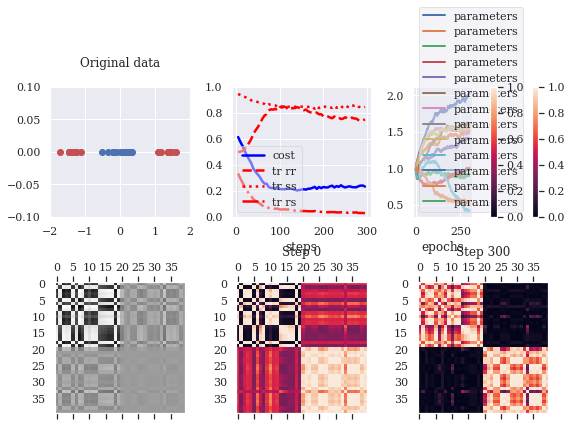

In [20]:
if plot:
    import seaborn as sns
    sns.set(context='notebook', font='serif')

    # Start figure
    fig = plt.figure(figsize=(9, 6))
    # Plotting 1: original data
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.set_title("Original data", pad=20)
    if len(A[0]) == 2:
        ax1.scatter(A[:, 0], A[:, 1], c='r')
        ax1.scatter(B[:, 0], B[:, 1], c='b')
        ax1.set_ylim((-2, 2))
    elif len(A[0]) == 1:
        ax1.scatter(A[:, 0], np.zeros(len(A)), c='r')
        ax1.scatter(B[:, 0], np.zeros(len(B)), c='b')
        ax1.set_ylim((-0.1, 0.1))

    ax1.set_xlim((-2, 2))
    # Plotting 2: gram matrix in original space
    ax5 = fig.add_subplot(2, 3, 4)
    ax5.grid(False)
    X_normal = [x / len(x) for x in X]
    gram_original = [[np.dot(x1, x2) for x1 in X_normal] for x2 in X_normal]
    ax5.matshow(gram_original, cmap='Greys')
    # Plotting 3: untrained gram matrix in Hilbert space
    ax6 = fig.add_subplot(2, 3, 5)
    ax6.set_title("Step 0", pad=20)
    ax6.grid(False)
    gram_before = [[circuit(init_pars, x1=x1, x2=x2) for x1 in X] for x2 in X]
    cax1 = ax6.matshow(gram_before, vmin=0, vmax=1)
    # Plotting 4: trained gram matrix in Hilbert space
    ax7 = fig.add_subplot(2, 3, 6)
    ax7.set_title("Step " + str(n_steps), pad=20)
    ax7.grid(False)
    gram_after = [[circuit(pars, x1=x1, x2=x2) for x1 in X] for x2 in X]
    cax2 = ax7.matshow(gram_after, vmin=0, vmax=1)
    # Plotting 5: cost
    if len(cst_history) > 0:
        ax2 = fig.add_subplot(2, 3, 2)
        cst_history = np.array(cst_history)
        rr_history = np.array(rr_history)
        ss_history = np.array(ss_history)
        rs_history = np.array(rs_history)
        ax2.plot(cst_history[:, 0], cst_history[:, 1],
                 color='blue', marker='', linestyle='-', linewidth=2.5, label="cost")
        ax2.plot(rr_history[:, 0], rr_history[:, 1],
                 color='red', marker='', linestyle='--', linewidth=2.5, label="tr rr")
        ax2.plot(ss_history[:, 0], ss_history[:, 1],
                 color='red', marker='', linestyle=':', linewidth=2.5, label="tr ss")
        ax2.plot(rs_history[:, 0], rs_history[:, 1],
                 color='red', marker='', linestyle='-.', linewidth=2.5, label="tr rs")
        plt.legend(fancybox=True, framealpha=0.5, loc='lower left')
        ax2.set_ylim((0, 1))
        ax2.set_xlabel("steps")


    # Plotting 6
    if len(cst_history) > 0:
        ax3 = fig.add_subplot(2, 3, 3)
        par_history = np.array(par_history)
        for i in range(len(par_history[0])):
            ax3.plot(range(len(par_history)), par_history[:, i], linewidth=2.0, label="parameters")
        ax3.set_xlabel("epochs")
        # fake line for legend
        ax3.plot([], linewidth=2.0, label="parameters")

    fig.colorbar(cax1, orientation="vertical", pad=0.2)
    fig.colorbar(cax2, orientation="vertical", pad=0.2)

    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.legend(fancybox=True, framealpha=0.5, loc='lower left')

    if save_plot:
        plt.savefig(name_output + ".svg")

    plt.show()

In [ ]:
X = np.loadtxt("./data/X_1d_sep_test.txt", ndmin=2)  # load features
Y = np.loadtxt("./data/Y_1d_sep_test.txt") 
path_to_featmap = "./trained_embeddings/1d_sep-l2-300s-4l-1w.npy"

In [ ]:
for x,y in zip(X,Y):
    predicted_y = predict(x, path_to_featmap, n_samples=None,
            probs_A=None, probs_B=None, binary=True, implementation="exact", seed=None)
    print('y:', y, ' predicted y: ', predicted_y)

In [ ]:
import numpy as np
import pennylane as qml

# set the random seed
np.random.seed(42)

# create a device to execute the circuit on
dev = qml.device("default.qubit", wires=4)
w = list(range(0,4))
@qml.qnode(dev)
def circuit(params):
    print(w)
    qml.RX(params[0], wires=w[0])
    qml.RY(params[1], wires=w[1])
    qml.RZ(params[2], wires=w[2])

    qml.RX(params[3], wires=w[0])
    qml.RY(params[4], wires=w[1])
    qml.CRZ(params[5], wires=[w[2],w[3]])
    
    return qml.expval(qml.PauliY(0) @ qml.PauliZ(2))

In [ ]:
m = list(range(0,4))
n = [*range(1, 4, 1)]
print(m)
print(n)

In [ ]:
generate_data('X_2d_sep.txt','Y_2d_sep.txt',40)

In [ ]:
data_dim = 1
if data_dim == 1:
    X = np.loadtxt("./data/X_1d_sep.txt", ndmin=2)  # load features
    Y = np.loadtxt("./data/Y_1d_sep.txt")  # load labels
elif data_dim == 2:
    X = np.loadtxt("./data/X_2d_sep.txt", ndmin=2)  # load features
    Y = np.loadtxt("./data/Y_2d_sep.txt")  # load labels

In [ ]:
# Divide inputs into classes
A = X[Y == -1]
B = X[Y == 1]
plot = True

In [ ]:
X[0][0]

In [ ]:
import numpy as np
import pennylane as qml

# set the random seed
np.random.seed(42)
types = 2
l=2
wires=range(0,2)
# create a device to execute the circuit on
dev = qml.device("default.qubit", wires=4)
@qml.qnode(dev)
def circuit_(weights, x1=None):

    # Load the two inputs into two different registers
    VQC(weights, x1, wires, n_layers=l, types = 1)

    # Measure overlap by checking ancilla
    return qml.expval(qml.PauliZ(0))

In [ ]:
params = pars_VQC(data_dim, wires, n_layers=l, types = 1)
print("Expectation value:", circuit_(params,x1=X[0]))
print(circuit_.draw())

In [ ]:
if plot:
    import seaborn as sns
    sns.set(context='notebook', font='serif')

    # Start figure
    fig = plt.figure(figsize=(9, 6))
    # Plotting 1: original data
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.set_title("Original data", pad=20)
    if len(A[0]) == 2:
        ax1.scatter(A[:, 0], A[:, 1], c='r')
        ax1.scatter(B[:, 0], B[:, 1], c='b')
        ax1.set_ylim((-2, 2))
    elif len(A[0]) == 1:
        ax1.scatter(A[:, 0], np.zeros(len(A)), c='r')
        ax1.scatter(B[:, 0], np.zeros(len(B)), c='b')
        ax1.set_ylim((-0.1, 0.1))

    plt.show()

In [ ]:
np.random.uniform(0,2*np.pi)

In [ ]:
def HVA_XXZ(weights, x, wires, n_layers=1):
    """

    :param weights: trainable weights of shape 2*n_layers*n_wires
    :param 1d x: input, len(x) is <= len(wires)
    :param wires: list of wires on which the feature map acts
    :param n_layers: number of repetitions of the first layer
    """
    n_wires = len(wires)

    if n_wires == 1:
        n_weights_needed = n_layers
    elif n_wires == 2:
        n_weights_needed = 3 * n_layers
    else:
        n_weights_needed = 2 * n_wires * n_layers

    if len(x) > n_wires:
        raise ValueError("Feat map can encode at most {} features (which is the "
                         "number of wires), got {}.".format(n_wires, len(x)))

    if len(weights) != n_weights_needed:
        raise ValueError("Feat map needs {} weights, got {}."
                         .format(n_weights_needed, len(weights)))

    for l in range(n_layers):

        # inputs
        for i in range(n_wires):
            # Either feed in feature
            if i < len(x):
                qml.RX(x[i], wires=wires[i])
            # or a Hadamard
            else:
                qml.Hadamard(wires=wires[i])

        # 1-d nearest neighbour coupling
        if n_wires == 1:
            qml.RY(weights[l], wires=wires[0])
        elif n_wires == 2:
            _entanglerZ(weights[l * 3 + 2], wires[0], wires[1])
            # local fields
            for i in range(n_wires):
                qml.RY(weights[l * 3 + i], wires=wires[i])
        else:
            for i in range(n_wires):
                if i < n_wires-1:
                    _entanglerZ(weights[l * 2 * n_wires + i], wires[i], wires[i + 1])
                else:
                    # enforce periodic boundary condition
                    _entanglerZ(weights[l * 2 * n_wires + i], wires[i], wires[0])
            # local fields
            for i in range(n_wires):
                qml.RY(weights[l * 2 * n_wires + n_wires + i], wires=wires[i])

    # repeat feature encoding once more at the end
    for i in range(n_wires):
        # Either feed in feature
        if i < len(x):
            qml.RX(x[i], wires=wires[i])
        # or a Hadamard
        else:
            qml.Hadamard(wires=wires[i])